In [38]:
import numpy as np
import pandas as pd

In [66]:
df = pd.read_csv('retentiondata_case.csv')
#print(df.shape)
#print(df.describe(include='all'))
print(df['left_flag'].value_counts())# summary stats

# Counts & percentages of missing values
missing_counts = df.isnull().sum()
missing_pct = (df.isnull().mean() * 100).round(2)

missing_summary = (
    pd.DataFrame({"n_missing": missing_counts, "pct_missing": missing_pct})
    .sort_values("pct_missing", ascending=False)
)

# Top 15 columns with most missing
missing_summary

left_flag
No     4140
Yes    1496
Name: count, dtype: int64


,n_missing,pct_missing
recent_offer,3106,55.11
internet_tech,1212,21.50
total_billed,8,0.14
gender,0,0.00
age_years,0,0.00
is_married,0,0.00
dependents_count,0,0.00
referred_friend,0,0.00
referrals_count,0,0.00
acct_ref,0,0.00


### Step 1 — Partitioning the data and prprocessing

In [68]:
### For classification problems, first determine the classes of your response variable
#print(df["left_flag"].dtype) 
#print(df["left_flag"].unique()) 

df["left_flag"] = df["left_flag"].str.strip().str.lower().map({"yes": 1, "no": 0})
 

In [69]:
Y = (df["left_flag"] == 1).astype(int) # returns True for rows where response == 1 and False otherwise then .astype(int) converts True→1 and False→0, so the “positive” label becomes 1
X = df.drop(columns=["left_flag","acct_ref", "cust_ref"]) 

### Train/test split and leakage (simple rule)

In [70]:
from sklearn.model_selection import train_test_split

# Train/test split (stratified for classification)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.30, random_state=99, stratify=Y
)

In [71]:
# Needed for preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


# 2) Identify column types from TRAIN ONLY
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

# 3) Build preprocessing (train-only learning happens during .fit())
# numeric variable imputation
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean"))
])

#categorical variable imputation
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="warn", sparse_output=False))  
])

#Aplpy the preprocessing to numeric and categorical variables
preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

### Step 2 — Train/ Fit Model: Classification Tree with Cross-Validation to choose best cp

In [72]:
#Modeling portion
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Decision tree model
dt = DecisionTreeClassifier(random_state=42)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", dt)
])

# cost complexity (cp) pruning parameter
param_grid = {
    "model__ccp_alpha": np.linspace(0.0, 0.005, 5),
}

grid = GridSearchCV(
    estimator=pipe, #model and preprocessing
    param_grid=param_grid, #tuning parameter values to try
    cv=cv,  #run cross validations
    scoring="roc_auc", #metric used in validation sets
    n_jobs=-1 #
)

# Fit learns preprocesssing, model TRAIN only
grid.fit(X_train, Y_train)

print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", round(grid.best_score_, 4))

Best params: {'model__ccp_alpha': np.float64(0.00125)}
Best CV ROC-AUC: 0.8442


cat__contract_term_Month-to-month    0.397695
num__referrals_count                 0.163835
cat__tech_support_std_No             0.108592
num__total_billed                    0.056902
num__dependents_count                0.043560
cat__internet_plan_Fiber optic       0.036688
num__tenure_mo                       0.035126
cat__referred_friend_Yes             0.032931
num__monthly_fee                     0.032651
cat__has_dependents_Yes              0.023271
cat__add_on_backup_No                0.012997
cat__stream_music_Yes                0.012585
cat__multi_line_No                   0.011352
cat__e_bill_opt_in_No                0.009615
cat__add_on_security_No              0.008167
num__age_years                       0.007419
cat__referred_friend_No              0.006614
cat__internet_tech_Fiber Optic       0.000000
cat__gender_Male                     0.000000
cat__e_bill_opt_in_Yes               0.000000
dtype: float64

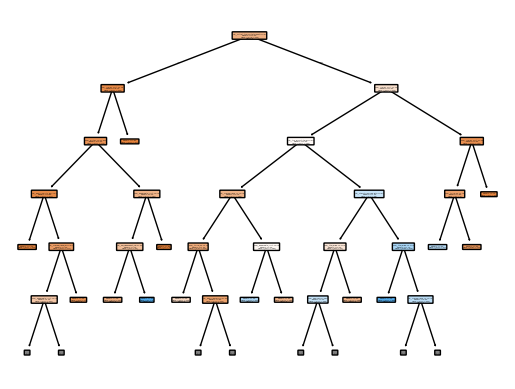

In [73]:
best_pipe = grid.best_estimator_          # Pipeline(preprocess → DecisionTree) refit on all X_train
best_dt   = best_pipe.named_steps["model"] # The tuned DecisionTreeClassifier

#get important features
pre = best_pipe.named_steps["preprocess"]
feature_names = pre.get_feature_names_out()
imp = pd.Series(best_dt.feature_importances_, index=feature_names).sort_values(ascending=False)
display(imp.head(20))  # top 20 features


#plot tree
from sklearn import tree
import matplotlib.pyplot as plt


class_names = [str(c) for c in best_dt.classes_]

tree.plot_tree(
    best_dt,
    feature_names=feature_names, # names of predictor variables 
    class_names=class_names, # Response variable needs to be a string for this
    filled=True,           # color nodes by majority class
    rounded=True,          # rounded boxes look nicer
    impurity=False,         # show Gini impurity (or entropy, depending on criterion)
    proportion=True,      # set True to show proportions instead of counts
    max_depth=5           # <-- for readability; shows top levels only 
    # set True to show proportions instead of counts
   # max_depth=4
)
plt.show()

### Step 3: get predictions on the test set

In [74]:
Y_prob = best_pipe.predict_proba(X_test)[:, 1]

### Step 4: Evaluate performance

Test ROC-AUC: 0.8529


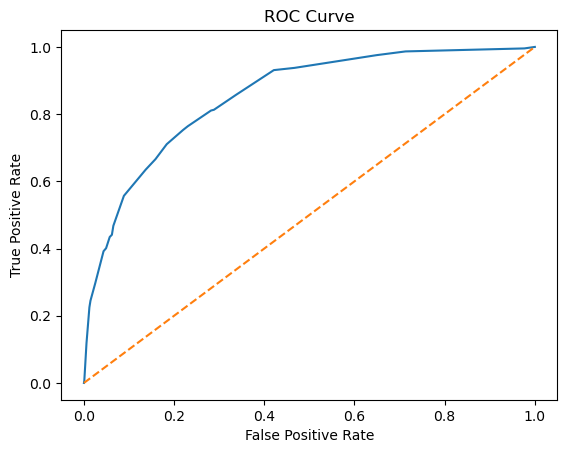

In [75]:
# Needed for Evaluation
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt  

# Test ROC-AUC
test_auc = roc_auc_score(Y_test, Y_prob)
print("Test ROC-AUC:", round(test_auc, 4))

# ROC curve (single plot; no custom colors)
fpr, tpr, _ = roc_curve(Y_test, Y_prob)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [5]:
# Source - https://stackoverflow.com/a/55499329
# Posted by Nico
# Retrieved 2026-01-30, License - CC BY-SA 4.0

!jupyter nbconvert your_notebook.ipynb --to pdf


[NbConvertApp] WARNING | pattern 'your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 

In [6]:
# Source - https://stackoverflow.com/a/52382663
# Posted by einsweniger
# Retrieved 2026-01-30, License - CC BY-SA 4.0

import os
print(os.environ['PATH'])


/opt/anaconda3/bin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin
